In [1]:
import numpy as np
import os
from IPython.display import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
Image(url="http://karpathy.github.io/assets/rnn/charseq.jpeg", width=500,)

## Prepare Data

In [3]:
batch_size = 32

### How does it look like?

In [4]:
with open("./rnn_data/names/Arabic.txt", encoding='utf-8') as f:
    d = f.readlines()

In [5]:
d

['Khoury\n',
 'Nahas\n',
 'Daher\n',
 'Gerges\n',
 'Nazari\n',
 'Maalouf\n',
 'Gerges\n',
 'Naifeh\n',
 'Guirguis\n',
 'Baba\n',
 'Sabbagh\n',
 'Attia\n',
 'Tahan\n',
 'Haddad\n',
 'Aswad\n',
 'Najjar\n',
 'Dagher\n',
 'Maloof\n',
 'Isa\n',
 'Asghar\n',
 'Nader\n',
 'Gaber\n',
 'Abboud\n',
 'Maalouf\n',
 'Zogby\n',
 'Srour\n',
 'Bahar\n',
 'Mustafa\n',
 'Hanania\n',
 'Daher\n',
 'Tuma\n',
 'Nahas\n',
 'Saliba\n',
 'Shamoon\n',
 'Handal\n',
 'Baba\n',
 'Amari\n',
 'Bahar\n',
 'Atiyeh\n',
 'Said\n',
 'Khouri\n',
 'Tahan\n',
 'Baba\n',
 'Mustafa\n',
 'Guirguis\n',
 'Sleiman\n',
 'Seif\n',
 'Dagher\n',
 'Bahar\n',
 'Gaber\n',
 'Harb\n',
 'Seif\n',
 'Asker\n',
 'Nader\n',
 'Antar\n',
 'Awad\n',
 'Srour\n',
 'Shadid\n',
 'Hajjar\n',
 'Hanania\n',
 'Kalb\n',
 'Shadid\n',
 'Bazzi\n',
 'Mustafa\n',
 'Masih\n',
 'Ghanem\n',
 'Haddad\n',
 'Isa\n',
 'Antoun\n',
 'Sarraf\n',
 'Sleiman\n',
 'Dagher\n',
 'Najjar\n',
 'Malouf\n',
 'Nahas\n',
 'Naser\n',
 'Saliba\n',
 'Shamon\n',
 'Malouf\n',
 'Kalb\n'

### load X, y

In [6]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"

# 유니코드 문자열을 일반 ASCII로 변환. http://stackoverflow.com/a/518232/2809427 
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [7]:
data = {'X': [], 'y': []}
for base_dir,_,fnames in os.walk('./rnn_data/names/'):
    for fname in fnames:
        with open(os.path.join(base_dir, fname), encoding='utf-8') as f:
            dd = f.readlines()
        data['X'].extend([unicodeToAscii(d.split("\n")[0]) for d in dd])
        data['y'].extend([fname.split(".txt")[0]]*len(dd))

In [8]:
set(data['y'])

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [9]:
data['X'][0]

'Khoury'

### RNN input matrix를 만들기 위한 조건
* one-hot vector이므로 character의 사전
* character set input이므로 각 word의 character의 개수
* max 길이에 맞춰서 padding
* Input: 
    * seq_length x batch_size x input_size (embedding_dimension in this case)
    * batch_size x seq_length x input_size (embedding_dimension in this case) (batch_first = True)

In [10]:
char_dict = dict()
char_len = []

for x in data['X']:
    for xx in x:
        first_char = char_dict.get(xx, None)
        if first_char == None:
            char_dict[xx] = len(char_dict.keys())
        else:
            continue
    char_len.append(len(x))
        
input_dim = len(char_dict.keys()) # num of set of characters

In [11]:
input_dim

55

In [12]:
char_dict

{'K': 0,
 'h': 1,
 'o': 2,
 'u': 3,
 'r': 4,
 'y': 5,
 'N': 6,
 'a': 7,
 's': 8,
 'D': 9,
 'e': 10,
 'G': 11,
 'g': 12,
 'z': 13,
 'i': 14,
 'M': 15,
 'l': 16,
 'f': 17,
 'B': 18,
 'b': 19,
 'S': 20,
 'A': 21,
 't': 22,
 'T': 23,
 'n': 24,
 'H': 25,
 'd': 26,
 'w': 27,
 'j': 28,
 'I': 29,
 'Z': 30,
 'm': 31,
 'k': 32,
 'W': 33,
 'C': 34,
 'Q': 35,
 'R': 36,
 'F': 37,
 'c': 38,
 'E': 39,
 'Y': 40,
 'J': 41,
 'L': 42,
 'O': 43,
 'P': 44,
 ' ': 45,
 'X': 46,
 'p': 47,
 'v': 48,
 'x': 49,
 'U': 50,
 'V': 51,
 'q': 52,
 "'": 53,
 ',': 54}

In [13]:
seq_len = max(char_len)

In [14]:
seq_len

19

In [15]:
# padding -> 0 vector 로
padded_X = []
zero_vector = [0]*input_dim
for x in data['X']:
    char_list = []
    for xx in x:
        char_vector = [0]*input_dim
        char_idx = char_dict[xx]
        char_vector[char_idx]=1
        char_list.append(char_vector)
    char_list.extend([zero_vector]*(seq_len - len(x)))
    padded_X.append(char_list)

padded_X = np.array(padded_X, dtype=np.float)

In [16]:
padded_X.shape # batch, seq_len, input_dim

(20074, 19, 55)

In [17]:
print("data num: {}".format(padded_X.shape[0]))
print("seq len: {}".format(padded_X.shape[1]))
print("input dim: {}".format(padded_X.shape[2]))

data num: 20074
seq len: 19
input dim: 55


### y

In [18]:
lang2idx = dict()
idx2lang = dict()
for y in set(data['y']):
    idx = len(lang2idx)
    lang2idx[y] = idx
    idx2lang[idx] = y

In [19]:
lang2idx

{'Dutch': 0,
 'Italian': 1,
 'Greek': 2,
 'Polish': 3,
 'Vietnamese': 4,
 'English': 5,
 'German': 6,
 'Portuguese': 7,
 'Scottish': 8,
 'Chinese': 9,
 'French': 10,
 'Czech': 11,
 'Arabic': 12,
 'Russian': 13,
 'Irish': 14,
 'Korean': 15,
 'Japanese': 16,
 'Spanish': 17}

In [20]:
y = []
for yy in data['y']:
    y.append(lang2idx[yy])

In [21]:
y = np.array(y)

In [22]:
y.shape

(20074,)

## Model

In [23]:
use_cuda = torch.cuda.is_available()

In [36]:
class LSTM(nn.Module):
    
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=128, batch_first=True)
        self.out = nn.Linear(128, len(lang2idx.keys()))
        if use_cuda:
            self.lstm = self.lstm.cuda()
            self.out = self.out.cuda()
            
    def forward(self, x, seq_len):
        """
        x: (batch_size, seq(time), input_dim)
        seq_len: (batch_size)
        """ 
        h, _ = self.lstm(x)
        # Implementation of the last relevant output indexing
        idx = (seq_len - 1).view(-1,1,1).expand(h.size(0), 1, h.size(2)) # (batch_size, seq, hidden_dim)
        last_h = h.gather(1, idx).squeeze(dim=1) # (batch_size, seq, hidden_dim) -> 하나의 batch는 마지막 output vector로 구성된 matrix
#         print(last_h.size()) # [batch, 128] 
        o = self.out(last_h) # (batch_size, out_dim)
        return F.softmax(o, dim=1)

In [37]:
model = LSTM()

## Train model

### prepare batch generator

In [26]:
shuffle_idx = list(range(len(data['y'])))
np.random.shuffle(shuffle_idx)
trn_num = int(len(data['y'])*0.8)
trn_idxs = shuffle_idx[:trn_num]
val_idxs = shuffle_idx[trn_num:]

In [27]:
len(val_idxs)

4015

In [28]:
trn_X, trn_y, trn_seq_len = torch.from_numpy(padded_X[trn_idxs]), torch.from_numpy(y[trn_idxs]).long(), torch.from_numpy(np.array(char_len)[trn_idxs])
trn = data_utils.TensorDataset(trn_X, trn_y, trn_seq_len)
trn_loader = data_utils.DataLoader(trn, batch_size=batch_size, shuffle=True, drop_last=False)

val_X, val_y, val_seq_len = torch.from_numpy(padded_X[val_idxs]), torch.from_numpy(y[val_idxs]).long(), torch.from_numpy(np.array(char_len)[val_idxs])
val = data_utils.TensorDataset(val_X, val_y, val_seq_len)
val_loader = data_utils.DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=False)

In [38]:
num_epochs = 50
num_batches = len(trn_loader)
val_ckpt = 250
learning_rate = 0.005
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [39]:
trn_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    trn_loss_batch = 0.0
    trn_corr_batch = 0
    for i, trn_data in enumerate(trn_loader):
        trn_X, trn_y, trn_seq_len = trn_data
        trn_seq_len = trn_seq_len.type(torch.LongTensor)
        if use_cuda:
            trn_X = trn_X.float().cuda()
            trn_y = trn_y.cuda()
            trn_seq_len = trn_seq_len.cuda()

        optimizer.zero_grad()
        model_y = model(trn_X, trn_seq_len)
        loss = criterion(model_y, trn_y)
        loss.backward()
        optimizer.step()
        
        trn_loss_batch += loss
        trn_corr = len(trn_y[trn_y == model_y.argmax(dim=1)])
        trn_corr_batch += trn_corr
        
        if (i+1) % val_ckpt == 0:
            with torch.no_grad():
                val_loss_all = 0.0
                val_corr_all = 0
                for j, val_data in enumerate(val_loader):
                    val_X, val_y, val_seq_len = val_data
                    val_seq_len = val_seq_len.type(torch.LongTensor)
                    if use_cuda:
                        val_X = val_X.float().cuda()
                        val_y = val_y.cuda()
                        val_seq_len = val_seq_len.cuda()

                    val_model_y = model(val_X, val_seq_len)
                    val_loss = criterion(val_model_y, val_y)
                    val_loss_all += val_loss
                    
                    val_corr = len(val_y[val_y == val_model_y.argmax(dim=1)])
                    val_corr_all += val_corr
        
            trn_loss_summary = trn_loss_batch / val_ckpt
            trn_acc_summary = trn_corr_batch / (val_ckpt*batch_size) * 100
            val_loss_summary = val_loss_all / len(val_loader)
            val_acc_summary = val_corr_all / (len(val_loader)*batch_size) * 100
            
            print("epoch: {}/{} | step: {}/{} | trn_loss: {:.4f} | trn_acc: {:.2f}% | val_loss: {:.4f} | val_acc: {:.2f}%".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss_summary, trn_acc_summary, val_loss_summary, val_acc_summary
            ))

            trn_loss_list.append(trn_loss_summary)
            val_loss_list.append(val_loss_summary)

            trn_loss_batch = 0.0
            trn_corr_batch = 0
        
print("finish Training")

epoch: 1/50 | step: 250/502 | trn_loss: 2.5279 | trn_acc: 45.89% | val_loss: 2.5018 | val_acc: 47.74%
epoch: 1/50 | step: 500/502 | trn_loss: 2.5119 | trn_acc: 46.95% | val_loss: 2.4984 | val_acc: 47.97%
epoch: 2/50 | step: 250/502 | trn_loss: 2.5014 | trn_acc: 47.95% | val_loss: 2.4752 | val_acc: 50.37%
epoch: 2/50 | step: 500/502 | trn_loss: 2.4884 | trn_acc: 49.24% | val_loss: 2.4755 | val_acc: 50.37%
epoch: 3/50 | step: 250/502 | trn_loss: 2.4725 | trn_acc: 50.88% | val_loss: 2.4824 | val_acc: 49.90%
epoch: 3/50 | step: 500/502 | trn_loss: 2.4713 | trn_acc: 51.04% | val_loss: 2.4546 | val_acc: 52.26%
epoch: 4/50 | step: 250/502 | trn_loss: 2.4942 | trn_acc: 48.73% | val_loss: 2.4997 | val_acc: 47.87%
epoch: 4/50 | step: 500/502 | trn_loss: 2.4940 | trn_acc: 48.70% | val_loss: 2.4774 | val_acc: 50.15%
epoch: 5/50 | step: 250/502 | trn_loss: 2.4783 | trn_acc: 50.30% | val_loss: 2.4644 | val_acc: 51.54%
epoch: 5/50 | step: 500/502 | trn_loss: 2.4801 | trn_acc: 50.12% | val_loss: 2.463

epoch: 41/50 | step: 250/502 | trn_loss: 2.1398 | trn_acc: 84.28% | val_loss: 2.1984 | val_acc: 78.00%
epoch: 41/50 | step: 500/502 | trn_loss: 2.1405 | trn_acc: 84.25% | val_loss: 2.1957 | val_acc: 78.42%
epoch: 42/50 | step: 250/502 | trn_loss: 2.1401 | trn_acc: 84.29% | val_loss: 2.1931 | val_acc: 78.50%
epoch: 42/50 | step: 500/502 | trn_loss: 2.1339 | trn_acc: 84.97% | val_loss: 2.1925 | val_acc: 78.72%
epoch: 43/50 | step: 250/502 | trn_loss: 2.1368 | trn_acc: 84.58% | val_loss: 2.1903 | val_acc: 78.92%
epoch: 43/50 | step: 500/502 | trn_loss: 2.1310 | trn_acc: 85.17% | val_loss: 2.1986 | val_acc: 78.00%
epoch: 44/50 | step: 250/502 | trn_loss: 2.1381 | trn_acc: 84.41% | val_loss: 2.1942 | val_acc: 78.32%
epoch: 44/50 | step: 500/502 | trn_loss: 2.1293 | trn_acc: 85.31% | val_loss: 2.1963 | val_acc: 78.17%
epoch: 45/50 | step: 250/502 | trn_loss: 2.1313 | trn_acc: 85.14% | val_loss: 2.1939 | val_acc: 78.52%
epoch: 45/50 | step: 500/502 | trn_loss: 2.1323 | trn_acc: 85.05% | val_l

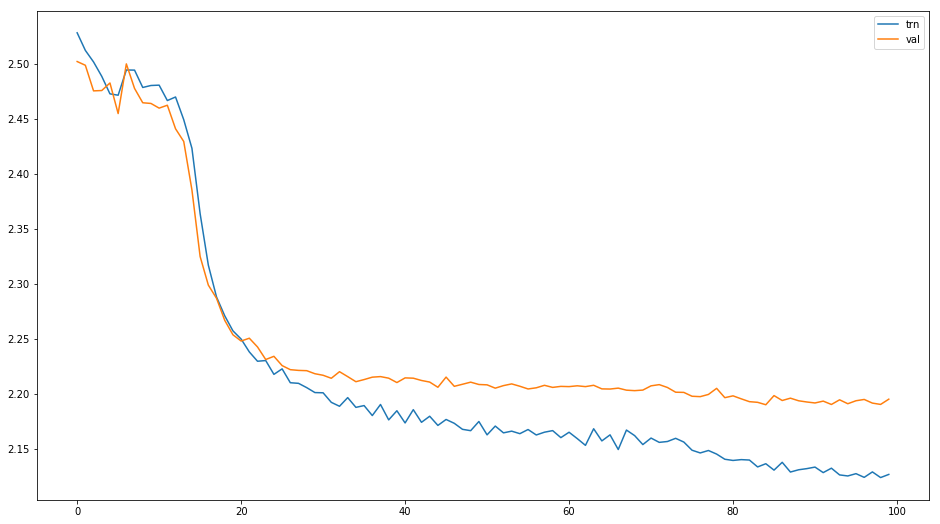

In [41]:
plt.figure(figsize=(16,9))
plt.plot(range(len(trn_loss_list)), trn_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list)
plt.legend(['trn', 'val'])